**Basic sizing process**

In [38]:
import numpy as np
import matplotlib.pyplot as plt

In [39]:
from sizing_functions import *

- Input values summary

(From `input.py` file)

In [40]:
print('--> WING')
print('\tSurface\t', w_S, '\tm^2')
print('\tSpan\t', w_span, '\tm')
print('\tChord\t', w_chord, '\tm^2')

print('\n--> FUSELAGE')
print('\tVolume\t', fus_volume, '\tm^3')
print('\tSwet\t', fus_S_wet, '\tm^2')


--> WING
	Surface	 2.1 	m^2
	Span	 4.2 	m
	Chord	 0.5 	m^2

--> FUSELAGE
	Volume	 0.094 	m^3
	Swet	 1.6 	m^2


- Input data for sizing process

In [41]:
#---- INPUTS FOR TAILPLANE SIZING ----
ht_V = 0.6
ht_arm = 1.1
ht_AR = 4
ht_taper = 1

vt_V = 0.05
vt_arm = 1.1
vt_AR = 2
vt_taper = 1

#---- INPUTS FOR PARASITIC DRAG ESTIMATION ----
# airspeed at which CD0 is estimated
V_drag = 15.0
# laminar/turbulent surface ratio
w_x_tr = 0.10
ht_x_tr = 0.10
vt_x_tr = 0.10
fus_x_tr = 0.00
# skin roughness
skin_roughness = 0.634e-5 # [m], for smooth paint (Raymer)


#---- INPUTS FOR FLAPS SIZING ----
# flaps chord/wing chord
w_flaps_chord_ratio = 0.25
w_flaps_Delta_C_l_max = 1.0

- Tailplane sizing

In [42]:
ht_sizing, vt_sizing = tailplane_sizing(\
    ht_V, ht_arm, ht_AR, ht_taper, \
    vt_V, vt_arm, vt_AR, vt_taper, \
    w_S, w_chord, w_span)

ht_S, ht_span, ht_chord = ht_sizing
vt_S, vt_span, vt_chord = vt_sizing

del ht_sizing
del vt_sizing

- Neutral point

In [43]:
np_x = neutral_point(ht_arm, ht_S, ht_AR)

- Parasitic drag

In [44]:
ht_dim = [ht_S, ht_span, ht_chord, ht_t_c, ht_x_c_max_t]
vt_dim = [vt_S, vt_span, vt_chord, vt_t_c, vt_x_c_max_t]

C_D_0 = parasitic_drag(
    V_drag, skin_roughness, w_x_tr, ht_dim, ht_x_tr, \
    vt_dim, vt_x_tr, fus_S_wet, fus_x_tr)

del ht_dim
del vt_dim

- Flaps

In [45]:
w_flaps_span_stations = flaps_sizing(w_flaps_chord_ratio, w_flaps_Delta_C_l_max)

**Results**

In [46]:
print('--> HORIZONTAL STABILISER')
print('\tSurface\t', ht_S, '\tm^2')
print('\tSpan\t', ht_span, '\tm')
print('\tChord\t', ht_chord, '\tm^2')

print('\n--> VERTICAL STABILISER')
print('\tSurface\t', vt_S, '\tm^2')
print('\tSpan\t', vt_span, '\tm')
print('\tChord\t', vt_chord, '\tm^2')

print('\n--> NEUTRAL POINT')
print('\tX_np\t', np_x, '\tm')
print('\t\t', np_x/w_chord*100, '\t% of wing chord')

print('\n--> PARASITIC DRAG')
print('\tC_D0\t', C_D_0, '\t-')

print('\n--> FLAPS')
print('\ty_i\t', w_flaps_span_stations[0]*w_span/2, '\t\tm')
print('\ty_i\t', w_flaps_span_stations[0], '\t\t% of wing span')
print('\ty_o\t', w_flaps_span_stations[1]*w_span/2, '\tm')
print('\ty_o\t', w_flaps_span_stations[1], '\t% of wing span')


--> HORIZONTAL STABILISER
	Surface	 0.5727272727272726 	m^2
	Span	 1.513574937328539 	m
	Chord	 0.37839373433213475 	m^2

--> VERTICAL STABILISER
	Surface	 0.40090909090909094 	m^2
	Span	 0.8954430086935639 	m
	Chord	 0.44772150434678193 	m^2

--> NEUTRAL POINT
	X_np	 0.22166758901818928 	m
		 44.333517803637854 	% of wing chord

--> PARASITIC DRAG
	C_D0	 0.029970434746233416 	-

--> FLAPS
	y_i	 0.126 		m
	y_i	 0.06 		% of wing span
	y_o	 1.0360000000000003 	m
	y_o	 0.49333333333333346 	% of wing span


**Plots**

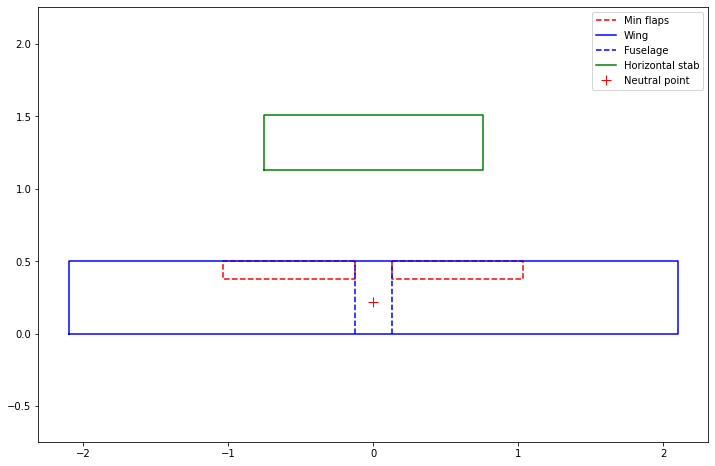

In [58]:
fig = plt.figure(figsize=(12,8))

def plot_wing():
    x_wing = [-w_span/2, w_span/2, w_span/2, -w_span/2, -w_span/2]
    y_wing = [0, 0, w_chord, w_chord, 0]

    plt.plot(x_wing, y_wing, 'b-', label='Wing')

    plt.plot([fus_width/2, fus_width/2], [-0.*w_chord, 1.0*w_chord], 'b--', label='Fuselage')
    plt.plot([-fus_width/2, -fus_width/2], [-0.*w_chord, 1.0*w_chord], 'b--')

def plot_flaps():
    x_flaps_plain = [fus_width/2, w_span/2*w_flaps_span_stations[1], \
        w_span/2*w_flaps_span_stations[1], fus_width/2, fus_width/2]
    y_flaps = [w_chord, w_chord, (1-w_flaps_chord_ratio)*w_chord, (1-w_flaps_chord_ratio)*w_chord, w_chord]

    plt.plot(x_flaps_plain, y_flaps, 'r-', label='Min flaps')
    plt.plot([-x for x in x_flaps_plain], y_flaps, 'r-')


def plot_ht():
    x_ht = [-ht_span/2, ht_span/2, ht_span/2, -ht_span/2, -ht_span/2]

    y_LE_ht = 0.25*w_chord + ht_arm - 0.25*ht_chord
    y_ht = [y_LE_ht, y_LE_ht, y_LE_ht+ht_chord, y_LE_ht+ht_chord, y_LE_ht]

    plt.plot(x_ht, y_ht, 'g-', label='Horizontal stab')

def plot_np():
    plt.plot(0, np_x, 'r+', markersize=10, label='Neutral point')


plot_flaps()
plot_wing()
plot_ht()
plot_np()
plt.axis('equal')
plt.legend()
plt.show()
